## **Load and Clean the Data**

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
df = pd.read_json('transactions.txt', lines=True)
df.head(5)

ValueError: Expected object or value

In [95]:
df.shape

(787719, 30)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             787719 non-null  int64  
 1   customerId                787719 non-null  int64  
 2   creditLimit               787719 non-null  int64  
 3   availableMoney            787719 non-null  float64
 4   transactionDateTime       787719 non-null  object 
 5   transactionAmount         787719 non-null  float64
 6   merchantName              787718 non-null  object 
 7   acqCountry                787718 non-null  object 
 8   merchantCountryCode       787718 non-null  object 
 9   posEntryMode              787718 non-null  object 
 10  posConditionCode          787718 non-null  object 
 11  merchantCategoryCode      787718 non-null  object 
 12  currentExpDate            787718 non-null  object 
 13  accountOpenDate           787718 non-null  o

In [5]:
print('Maximum date: ', pd.to_datetime(df['transactionDateTime']).max())
print('Minimum date: ', pd.to_datetime(df['transactionDateTime']).min())

Maximum date:  2016-12-30 23:59:45
Minimum date:  2016-01-01 00:01:02


- Dataset has information for 786363 transactions
- There are 29 variables
- The data covers transactions between January and December 2016

In [6]:
df['isFraud'].value_counts()

,count
isFraud,
False,775287
True,12432


Out of 786,363 transactions, there are 12,417 transactions that are fraud.

In [7]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
False,0.984218
True,0.015782


The rate of fraudulent transaction is about 1.58%.

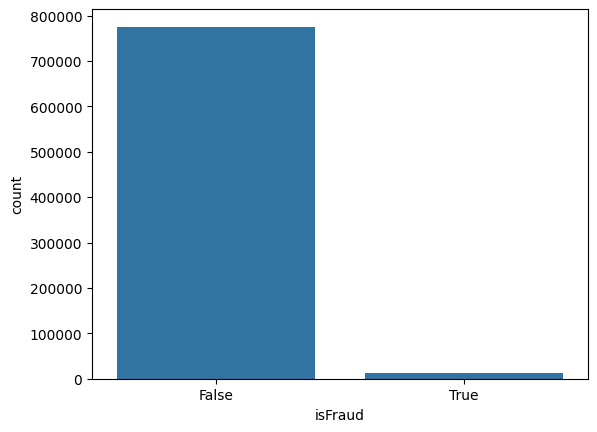

In [8]:
sns.countplot(x = "isFraud", data = df)
plt.show()

The dataset is highly imbalanced!

In [9]:
#Check columns with null values
df.isnull().any()

,0
accountNumber,False
customerId,False
creditLimit,False
availableMoney,False
transactionDateTime,False
transactionAmount,False
merchantName,True
acqCountry,True
merchantCountryCode,True
posEntryMode,True


There is no missing value.

### Unique Values

In [10]:
#Check the number of unique values in each column
df.nunique()

,0
accountNumber,5000
customerId,5000
creditLimit,10
availableMoney,521915
transactionDateTime,776637
transactionAmount,66038
merchantName,2490
acqCountry,5
merchantCountryCode,5
posEntryMode,6


Columns including echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, and recurringAuthInd have only 1 unique value. These columns have no predictive value so I will drop them.

In [11]:
#Drop columns that have only 1 value
cols_drop = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
df = df.drop(columns=cols_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             787719 non-null  int64  
 1   customerId                787719 non-null  int64  
 2   creditLimit               787719 non-null  int64  
 3   availableMoney            787719 non-null  float64
 4   transactionDateTime       787719 non-null  object 
 5   transactionAmount         787719 non-null  float64
 6   merchantName              787718 non-null  object 
 7   acqCountry                787718 non-null  object 
 8   merchantCountryCode       787718 non-null  object 
 9   posEntryMode              787718 non-null  object 
 10  posConditionCode          787718 non-null  object 
 11  merchantCategoryCode      787718 non-null  object 
 12  currentExpDate            787718 non-null  object 
 13  accountOpenDate           787718 non-null  o

### Empty Strings

In [12]:
#Check columns with empty strings
(df == '').any()

,0
accountNumber,False
customerId,False
creditLimit,False
availableMoney,False
transactionDateTime,False
transactionAmount,False
merchantName,False
acqCountry,True
merchantCountryCode,True
posEntryMode,True


There are 5 columns that have empty strings.

In [13]:
df['acqCountry'].value_counts()

,count
acqCountry,
US,776052
,4565
MEX,3134
CAN,2428
PR,1539


### Handling empty strings
There are some rows in the dataset that contain empty strings. To handle this, I consider two options:
- Option 1: Replace empty values with a placeholder ("Missing")
- Option 2: Drop rows with empty values

Option 1 keeps all rows and allows the model to potentially learn fron the missingness itself but may add noise. Option 2 offers cleaner data but may lose some important training samples.

I will use both options and compare their impact on model performance.




**Option 1: Replace empty values with a placeholder**

In [14]:
#Replace empty strings with 'Missing'
df_missing = df.replace('', 'Missing')
#Check if the df still has empty strings
(df_missing == '').any()

,0
accountNumber,False
customerId,False
creditLimit,False
availableMoney,False
transactionDateTime,False
transactionAmount,False
merchantName,False
acqCountry,False
merchantCountryCode,False
posEntryMode,False


**Option 2: Drop rows with empty values**

In [15]:
#Drop rows that contain empty strings
df_dropped = df[~(df == '').any(axis=1)].copy()
#Check rows and columns of this df
df_dropped.shape

(778014, 24)

For this approach, there are 9,695 rows that have empty values and were dropped

For now, I will continue using the original DataFrame to explore and preprocess the dataset. I will update these two DataFrames when I begin the modeling phase to compare their performance.

## **Exploratory Data Analysis**

### Categorical Variables

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             787719 non-null  int64  
 1   customerId                787719 non-null  int64  
 2   creditLimit               787719 non-null  int64  
 3   availableMoney            787719 non-null  float64
 4   transactionDateTime       787719 non-null  object 
 5   transactionAmount         787719 non-null  float64
 6   merchantName              787718 non-null  object 
 7   acqCountry                787718 non-null  object 
 8   merchantCountryCode       787718 non-null  object 
 9   posEntryMode              787718 non-null  object 
 10  posConditionCode          787718 non-null  object 
 11  merchantCategoryCode      787718 non-null  object 
 12  currentExpDate            787718 non-null  object 
 13  accountOpenDate           787718 non-null  o

Let's take a look at these fields:
- accountNumber
- customerId
- creditLimit
- cardCVV
- enteredCVV
- cardLast4Digits

In [17]:
df[['accountNumber', 'customerId', 'creditLimit',  'cardCVV', 'enteredCVV', 'cardLast4Digits']].head(5)

,accountNumber,customerId,creditLimit,cardCVV,enteredCVV,cardLast4Digits
0,737265056,737265056,5000,414.0,414.0,1803.0
1,737265056,737265056,5000,486.0,486.0,767.0
2,737265056,737265056,5000,486.0,486.0,767.0
3,737265056,737265056,5000,486.0,486.0,767.0
4,830329091,830329091,5000,885.0,885.0,3143.0


In [18]:
df[['accountNumber', 'customerId', 'creditLimit',  'cardCVV', 'enteredCVV', 'cardLast4Digits']].nunique()

,0
accountNumber,5000
customerId,5000
creditLimit,10
cardCVV,899
enteredCVV,976
cardLast4Digits,5245


In [19]:
#Check if accountNumber and customerId are the same for all rows
df[(df['accountNumber']) != (df['customerId'])]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mercharchantState


accountNumber and customerId are the same across all rows. I will drop accountNumber from the dataset to reduce redundancy.

In [20]:
df = df.drop(['accountNumber'], axis=1)

customerId is categorical variable but is stored as integer because of its numerical format. I will convert it to categorical type.

In [21]:
df['customerId'] = df['customerId'].astype('category')

I will drop cardLast4Digits

In [22]:
df = df.drop(['cardLast4Digits'], axis=1)

If 'enteredCVV' is different from 'cardCVV', it may be a signal for suspicious behavior. I will create a new binary feature called "isMatchedCVV" to see if 'enteredCVV' is the same as 'cardCVV'. I will then drop 'enteredCVV' and 'cardCVV' columns.

In [23]:
df['isMatchedCVV'] = df['cardCVV'] == df['enteredCVV']
df=df.drop(columns=['enteredCVV', 'cardCVV'], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   customerId                787719 non-null  category
 1   creditLimit               787719 non-null  int64   
 2   availableMoney            787719 non-null  float64 
 3   transactionDateTime       787719 non-null  object  
 4   transactionAmount         787719 non-null  float64 
 5   merchantName              787718 non-null  object  
 6   acqCountry                787718 non-null  object  
 7   merchantCountryCode       787718 non-null  object  
 8   posEntryMode              787718 non-null  object  
 9   posConditionCode          787718 non-null  object  
 10  merchantCategoryCode      787718 non-null  object  
 11  currentExpDate            787718 non-null  object  
 12  accountOpenDate           787718 non-null  object  
 13  dateOfLastAddressChange   787

To analyze categorical variables more effectively, I will create a reusable function called explore_categorical that I can apply to each variable in the dataset.

I want to see:
- how frequent each category is
- how fraud is distributed across categories

In [25]:
def explore_categorical(col_name):
    #Number of time each category appears
    print("{0} Counts".format(col_name))
    print(df[col_name].value_counts())
    print("\n")

    #Converts the counts into percentages
    print("{0} Ratio".format(col_name))
    print(df[col_name].value_counts(normalize=True))
    print("\n")

    #Number of time fraud and non-fraud occurred
    print("{0} Default Counts".format(col_name))
    print(df.groupby(col_name, observed=False)['isFraud'].value_counts().unstack(level=-1))
    print("\n")

    #Converts the counts into percentages
    print("{0} Default Ratio".format(col_name))
    print(df.groupby(col_name, observed=False)['isFraud'].value_counts(normalize=True).unstack(level=-1))


In [26]:
explore_categorical('creditLimit')

creditLimit Counts
creditLimit
5000     202796
15000    139307
7500      97999
2500      75429
20000     68712
10000     56932
50000     48971
1000      36445
250       34025
500       27103
Name: count, dtype: int64


creditLimit Ratio
creditLimit
5000     0.257447
15000    0.176849
7500     0.124409
2500     0.095756
20000    0.087229
10000    0.072275
50000    0.062168
1000     0.046266
250      0.043194
500      0.034407
Name: proportion, dtype: float64


creditLimit Default Counts
isFraud       False  True 
creditLimit               
250           33618    407
500           26638    465
1000          35899    546
2500          74313   1116
5000         199259   3537
7500          96709   1290
10000         56165    767
15000        136762   2545
20000         67796    916
50000         48128    843


creditLimit Default Ratio
isFraud         False     True 
creditLimit                    
250          0.988038  0.011962
500          0.982843  0.017157
1000         0.985019  0.0149

The most common credit limit is 5,000 (25.7% of all customers), followed by 15,000 and 7,500. The highest fraud ratios are 15,000 credit limit with 1.83%, followed by 5,000 and 50,000.

In [27]:
explore_categorical('merchantName')

merchantName Counts
merchantName
Uber                        25633
Lyft                        25556
oldnavy.com                 17020
staples.com                 17001
alibaba.com                 16978
                            ...  
Golds Gym #956354               2
Boost Mobile #104815            2
TMobile Wireless #602341        1
EZ Wireless #149871             1
Curves #849125                  1
Name: count, Length: 2490, dtype: int64


merchantName Ratio
merchantName
Uber                        0.032541
Lyft                        0.032443
oldnavy.com                 0.021607
staples.com                 0.021583
alibaba.com                 0.021553
                              ...   
Golds Gym #956354           0.000003
Boost Mobile #104815        0.000003
TMobile Wireless #602341    0.000001
EZ Wireless #149871         0.000001
Curves #849125              0.000001
Name: proportion, Length: 2490, dtype: float64


merchantName Default Counts
isFraud                      False 

The top merchants by frequency are Uber (3.26%) and Lyft (3.25%).

Merchants like walmart.com (2.64%), 1st Pub (2.75%), and staples.com (2.35%) have relatively higher fraud rates.



In [28]:
explore_categorical('transactionType')

transactionType Counts
transactionType
PURCHASE                746483
REVERSAL                 20338
ADDRESS_VERIFICATION     20198
                           699
Name: count, dtype: int64


transactionType Ratio
transactionType
PURCHASE                0.947653
REVERSAL                0.025819
ADDRESS_VERIFICATION    0.025641
                        0.000887
Name: proportion, dtype: float64


transactionType Default Counts
isFraud                False  True 
transactionType                    
                         685     14
ADDRESS_VERIFICATION   20080    118
PURCHASE              734521  11962
REVERSAL               20000    338


transactionType Default Ratio
isFraud                  False     True 
transactionType                         
                      0.979971  0.020029
ADDRESS_VERIFICATION  0.994158  0.005842
PURCHASE              0.983976  0.016024
REVERSAL              0.983381  0.016619


- PURCHASE makes up the vast majority of all fraud.
- ADDRESS_VERIFICATION has the lowest fraud rate.
- Unknown transaction type has the highest fraud rate.


In [29]:
explore_categorical('merchantCountryCode')

merchantCountryCode Counts
merchantCountryCode
US     779857
MEX      3147
CAN      2430
PR       1560
          724
Name: count, dtype: int64


merchantCountryCode Ratio
merchantCountryCode
US     0.990021
MEX    0.003995
CAN    0.003085
PR     0.001980
       0.000919
Name: proportion, dtype: float64


merchantCountryCode Default Counts
isFraud               False  True 
merchantCountryCode               
                        642     82
CAN                    2374     56
MEX                    3083     64
PR                     1533     27
US                   767654  12203


merchantCountryCode Default Ratio
isFraud                 False     True 
merchantCountryCode                    
                     0.886740  0.113260
CAN                  0.976955  0.023045
MEX                  0.979663  0.020337
PR                   0.982692  0.017308
US                   0.984352  0.015648


- Unknown merchantCountryCode shows highest fraud rate (11.3%)
- Non-US countries have slightly higher fraud rates than the US
- Given the volume of US transactions, most fraud still happens in the US

In [30]:
explore_categorical('customerId')

customerId Counts
customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
675656700        1
772075422        1
897071504        1
238928524        1
828800922        1
Name: count, Length: 5000, dtype: int64


customerId Ratio
customerId
380680241    0.041703
882815134    0.016743
570884863    0.013796
246251253    0.012913
369308035    0.009177
               ...   
675656700    0.000001
772075422    0.000001
897071504    0.000001
238928524    0.000001
828800922    0.000001
Name: proportion, Length: 5000, dtype: float64


customerId Default Counts
isFraud     False  True 
customerId              
100088067      74      1
100108752      18      0
100328049     103      0
100663626      31      0
100737756     177      1
...           ...    ...
999086814     672      5
999257059     158      2
999258704      87      1
999283629     141      0
999389635       9      0

[5000 rows x 2 columns]


customerId Default Rati

- There are 5,000 unique customers.
- Some customers have tens of thousands of transactions and some only have 1 transactions.
- A large number of customers have no fraud history.
- I will drop this column after finishing explore & preprocess the dataset as it's just an identifier, not a meaningful feature to predict.

In [31]:
explore_categorical('isMatchedCVV')

isMatchedCVV Counts
isMatchedCVV
True     780672
False      7047
Name: count, dtype: int64


isMatchedCVV Ratio
isMatchedCVV
True     0.991054
False    0.008946
Name: proportion, dtype: float64


isMatchedCVV Default Counts
isFraud        False  True 
isMatchedCVV               
False           6844    203
True          768443  12229


isMatchedCVV Default Ratio
isFraud          False     True 
isMatchedCVV                    
False         0.971193  0.028807
True          0.984335  0.015665


Majority of transactions (99.1%) have matched CVV but fraud is almost 2 times more likely when CVV doesn't match.

isMatchedCVV is a useful predictive feature as it differentiates fraud vs. non-fraud transactions.

In [32]:
explore_categorical('cardPresent')

cardPresent Counts
cardPresent
False    434095
True     353624
Name: count, dtype: int64


cardPresent Ratio
cardPresent
False    0.551078
True     0.448922
Name: proportion, dtype: float64


cardPresent Default Counts
isFraud       False  True 
cardPresent               
False        425124   8971
True         350163   3461


cardPresent Default Ratio
isFraud         False     True 
cardPresent                    
False        0.979334  0.020666
True         0.990213  0.009787


In [33]:
explore_categorical('cardPresent')

cardPresent Counts
cardPresent
False    434095
True     353624
Name: count, dtype: int64


cardPresent Ratio
cardPresent
False    0.551078
True     0.448922
Name: proportion, dtype: float64


cardPresent Default Counts
isFraud       False  True 
cardPresent               
False        425124   8971
True         350163   3461


cardPresent Default Ratio
isFraud         False     True 
cardPresent                    
False        0.979334  0.020666
True         0.990213  0.009787


- Slightly more transactions were made without the card present.
- Transactions without the card present are over 2 times more likely to be fraudulent.

In [34]:
explore_categorical('expirationDateKeyInMatch')

expirationDateKeyInMatch Counts
expirationDateKeyInMatch
False    786675
True       1044
Name: count, dtype: int64


expirationDateKeyInMatch Ratio
expirationDateKeyInMatch
False    0.998675
True     0.001325
Name: proportion, dtype: float64


expirationDateKeyInMatch Default Counts
isFraud                    False  True 
expirationDateKeyInMatch               
False                     774256  12419
True                        1031     13


expirationDateKeyInMatch Default Ratio
isFraud                      False     True 
expirationDateKeyInMatch                    
False                     0.984213  0.015787
True                      0.987548  0.012452


- Almost all transactions had expiration date mismatches (99.87%).
- When the expiration date matches, there is slightly lower fraud rate.

### Continous Variables

In [35]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,787719.000000,787719.000000,787719.000000,787719.000000
mean,10762.420038,6257.861224,136.961397,4504.558814
std,11644.353889,8897.793087,147.714757,6453.208589
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1078.740000,33.650000,689.180000
50%,7500.000000,3187.570000,87.870000,2449.110000
75%,15000.000000,7500.000000,191.440000,5280.665000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [36]:
corr = df[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']].corr()
corr.style.background_gradient()

,creditLimit,availableMoney,transactionAmount,currentBalance
creditLimit,1.000000,0.835438,0.005525,0.652513
availableMoney,0.835438,1.000000,-0.010157,0.128671
transactionAmount,0.005525,-0.010157,1.000000,0.023973
currentBalance,0.652513,0.128671,0.023973,1.000000


creditLimit shows a strong correlation with availableMoney (0.83) and a moderate correlation with currentBalance (0.65). To reduce multicollinearity and avoid redundancy among features, I will drop creditLimit from the dataset.

In [37]:
df = df.drop('creditLimit', axis=1)

In [38]:
#Summary statistics for transactionAmount
df.groupby('isFraud')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,775287.0,135.545872,146.513654,0.0,33.180,86.720,189.350,2011.54
True,12432.0,225.236644,189.588394,0.0,85.915,176.975,311.485,1608.35


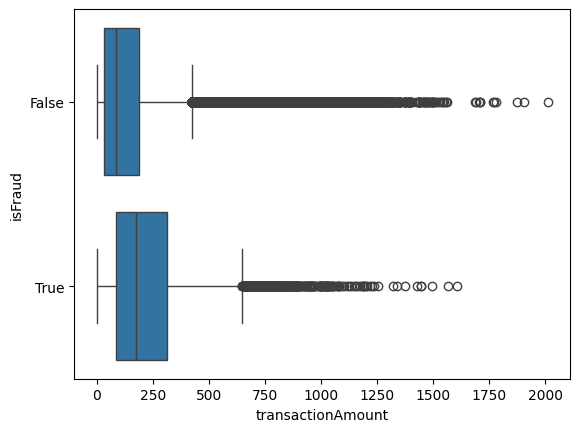

In [39]:
sns.boxplot(x='transactionAmount', y='isFraud', data=df, orient="h")
plt.show()

- Fraudulent transactions have a higher average transaction amount (mean ≈ 225) compared to non-fraudulent ones (mean ≈ 135).

- The median (50%) and upper quartile (75%) values are also notably higher for fraud cases.

In [40]:
print((df['transactionAmount'] == 0).sum())
df[df['transactionAmount'] == 0]['isFraud'].value_counts(normalize=True)

22285


,proportion
isFraud,
False,0.994436
True,0.005564


There are 22,225 transactions that are $0. Only 0.55% of these transactions are frauds so I will not take this into consideration.

In [41]:
#Summary statistics for currentBalance
df.groupby('isFraud')['currentBalance'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,775287.0,4498.239978,6442.621229,0.0,687.240,2444.44,5275.170,47498.81
True,12432.0,4898.615373,7071.395099,0.0,822.095,2746.34,5643.325,47473.94


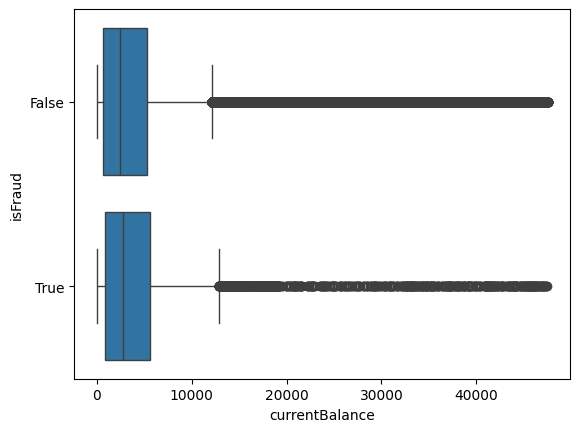

In [42]:
sns.boxplot(x='currentBalance', y='isFraud', data=df, orient="h")
plt.show()

In [43]:
#Summary statistics for availableMoney
df.groupby('isFraud')['availableMoney'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,775287.0,6259.605181,8900.682517,-1005.63,1078.7350,3188.790,7500.000,50000.0
True,12432.0,6149.104221,8715.370858,-614.39,1079.2725,3121.735,7503.835,50000.0


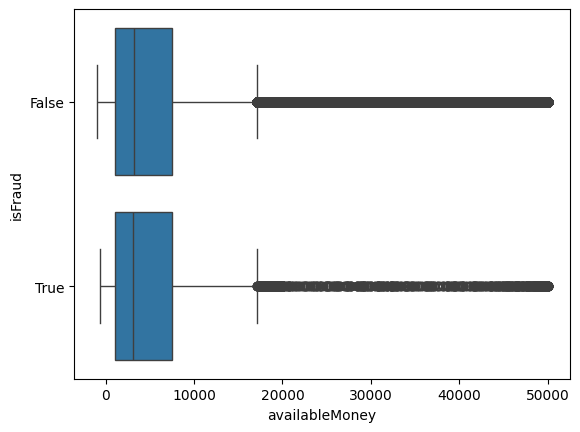

In [44]:
sns.boxplot(x='availableMoney', y='isFraud', data=df, orient="h")
plt.show()

Fraudulent and non-fraudulent distributions for availableMoney and currentBalance are very similar in terms of mean, median, and spread.

The boxplots show almost overlapping distributions, with many outliers.

## **Data Preprocessing**

In [45]:
#Convert transactionDateTime from categorical to datetime type
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customerId                787719 non-null  category      
 1   availableMoney            787719 non-null  float64       
 2   transactionDateTime       787719 non-null  datetime64[ns]
 3   transactionAmount         787719 non-null  float64       
 4   merchantName              787718 non-null  object        
 5   acqCountry                787718 non-null  object        
 6   merchantCountryCode       787718 non-null  object        
 7   posEntryMode              787718 non-null  object        
 8   posConditionCode          787718 non-null  object        
 9   merchantCategoryCode      787718 non-null  object        
 10  currentExpDate            787718 non-null  object        
 11  accountOpenDate           787718 non-null  object        
 12  da

### Handling duplicated reversal transactions

In [47]:
print("Number of reversal transactions: ", df[df['transactionType']=='REVERSAL'].shape[0])

Number of reversal transactions:  20338


In [52]:
# Filter reversal transactions
df_reversal = df[df['transactionType'] == 'REVERSAL']

# Sort by relevant features
df_reversal = df_reversal.sort_values(by=['customerId', 'merchantName', 'transactionAmount', 'transactionDateTime'])

# Group by key features
group_cols = ['customerId', 'merchantName', 'transactionAmount']

# Calculate previous time
df_reversal['prev_time'] = df_reversal.groupby(group_cols, observed=False)['transactionDateTime'].shift(1)

# Calculate time difference in minutes
df_reversal['time_diff_min'] = (df_reversal['transactionDateTime'] - df_reversal['prev_time']).dt.total_seconds() / 60

# Flag potential duplicates
df_reversal['isDupReversal'] = df_reversal['time_diff_min'].between(0, 10)

# View only those duplicates
df_reversal[df_reversal['isDupReversal']].shape


(35, 23)

In [57]:
#Calculate total amount of duplicated reversal transactions
(df_reversal[df_reversal['isDupReversal']]['transactionAmount']).sum()

np.float64(4635.6900000000005)

There are 35 transactions that are duplicates of reversal transactions.The total amount of these transactions are $4,635

In [61]:
# Filter non-reversal transactions
df_multi_swipe = df[df['transactionType'] != 'REVERSAL']

# Sort by relevant features
df_multi_swipe = df_multi_swipe.sort_values(by=['customerId', 'merchantName', 'transactionAmount', 'transactionDateTime'])

# Group by key features
group_cols = ['customerId', 'merchantName', 'transactionAmount']

# Calculate previous time
df_multi_swipe['prev_time'] = df_multi_swipe.groupby(group_cols, observed=False)['transactionDateTime'].shift(1)

# Calculate time difference in minutes
df_multi_swipe['time_diff_min'] = (df_multi_swipe['transactionDateTime'] - df_multi_swipe['prev_time']).dt.total_seconds() / 60

# Flag potential duplicates
df_multi_swipe['isMultiSwipe'] = df_multi_swipe['time_diff_min'].between(0, 10)

# View only those duplicates
df_multi_swipe[df_multi_swipe['isMultiSwipe']].shape

(9002, 23)

In [62]:
df_multi_swipe[df_multi_swipe['isMultiSwipe']]

,customerId,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,mercharchantState,isMatchedCVV,prev_time,time_diff_min,isMultiSwipe
541956,100088067,49275.09,2016-10-16 18:01:02,411.35,Fresh Flowers,US,US,02,08,online_gifts,...,PURCHASE,724.91,False,False,False,NaN,True,2016-10-16 18:01:00,0.033333,True
151518,100737756,177.98,2016-07-10 14:32:06,43.25,34th BBQ #166379,US,US,02,01,food,...,PURCHASE,72.02,True,False,False,NaN,True,2016-07-10 14:31:07,0.983333,True
151427,100737756,-44.75,2016-01-18 01:55:28,693.50,Franks Deli,US,US,05,01,food,...,PURCHASE,294.75,True,False,False,NaN,True,2016-01-18 01:55:24,0.066667,True
151428,100737756,-535.03,2016-01-18 01:58:26,693.50,Franks Deli,US,US,05,01,food,...,PURCHASE,785.03,True,False,False,NaN,True,2016-01-18 01:55:28,2.966667,True
151513,100737756,250.00,2016-07-02 12:07:00,211.22,South Steakhouse #73819,US,US,09,01,food,...,PURCHASE,0.00,True,False,False,NaN,True,2016-07-02 12:05:04,1.933333,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389018,999086814,503.05,2016-12-19 02:49:22,22.76,apple.com,US,US,05,01,online_retail,...,PURCHASE,9496.95,False,False,False,NaN,True,2016-12-19 02:48:24,0.966667,True
388400,999086814,5450.99,2016-01-23 09:22:35,178.57,sears.com,US,US,02,01,online_retail,...,PURCHASE,4549.01,False,False,False,NaN,True,2016-01-23 09:20:02,2.550000,True
388759,999086814,5418.98,2016-08-04 00:04:03,172.50,staples.com,US,US,05,01,online_retail,...,PURCHASE,4581.02,False,False,False,NaN,True,2016-08-04 00:02:27,1.600000,True
569654,999257059,14177.84,2016-01-14 16:51:22,47.58,Wall Street News,US,US,09,01,subscriptions,...,PURCHASE,822.16,False,False,False,NaN,True,2016-01-14 16:48:41,2.683333,True


### Handling DateTime

In [66]:
#Calculate the age of card in terms of days
df['cardAge'] = df['transactionDateTime'] - pd.to_datetime(df['accountOpenDate'])
df['cardAge'] = df['cardAge'].dt.days

In [67]:
#Summary statistic of cardAge
df.groupby('isFraud')['cardAge'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,775286.0,883.995256,697.598883,1.0,430.0,680.0,1111.00,9990.0
True,12432.0,851.136503,677.878030,12.0,427.0,667.0,1007.25,9890.0


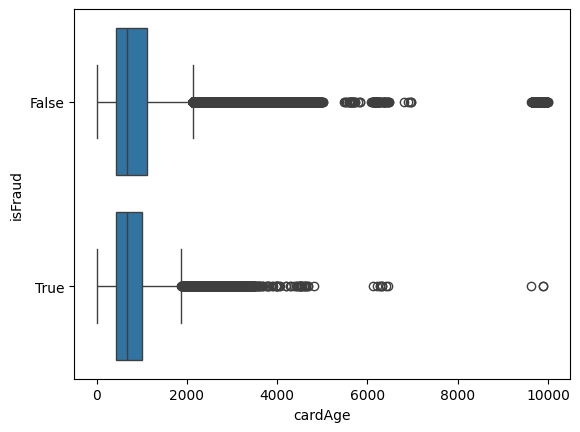

In [68]:
sns.boxplot(x='cardAge', y='isFraud', data=df, orient="h")
plt.show()

In [ ]:
df.nunique()

customerId                    5000
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
transactionType                  4
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
isMatchedCVV                     2
cardAge                       5102
dtype: int64

In [79]:
df = df.drop(columns=['currentExpDate', 'accountOpenDate', 'customerId', 'merchantName', 'dateOfLastAddressChange'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786363 entries, 541917 to 108107
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   availableMoney            786363 non-null  float64       
 1   transactionDateTime       786363 non-null  datetime64[ns]
 2   transactionAmount         786363 non-null  float64       
 3   acqCountry                786363 non-null  object        
 4   merchantCountryCode       786363 non-null  object        
 5   posEntryMode              786363 non-null  object        
 6   posConditionCode          786363 non-null  object        
 7   merchantCategoryCode      786363 non-null  object        
 8   transactionType           786363 non-null  object        
 9   currentBalance            786363 non-null  float64       
 10  cardPresent               786363 non-null  bool          
 11  expirationDateKeyInMatch  786363 non-null  bool          
 12  is

### Variable Encoding

I will use pd.get_dummies to one hot encode our categorical variables

In [73]:
categorical_cols = ['acqCountry', 'merchantCountryCode', 'posEntryMode',
                    'posConditionCode', 'merchantCategoryCode', 'transactionType']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [74]:
df = df.drop('transactionDateTime', axis=1)

### Scaling numerical features

I will use min standard scaling to bring continuous variables into the same range for the use of Logistic Regression.

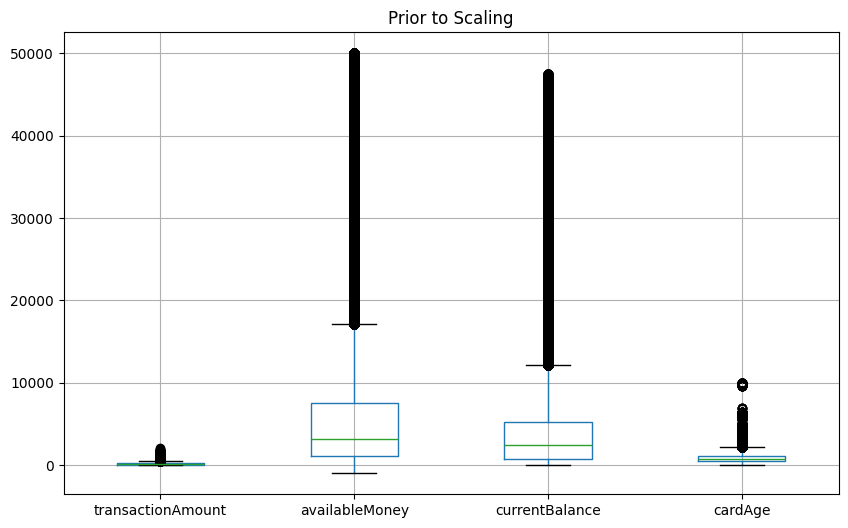

In [69]:
#Visualize numerical features before scaling
numerical_cols = ['transactionAmount', 'availableMoney', 'currentBalance', 'cardAge', ]
plt.figure(figsize=(10, 6))
df[numerical_cols].boxplot()
plt.title('Prior to Scaling')
plt.show()

In [85]:
df_logistic = df

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_logistic[numerical_cols] = scaler.fit_transform(df_logistic[numerical_cols])

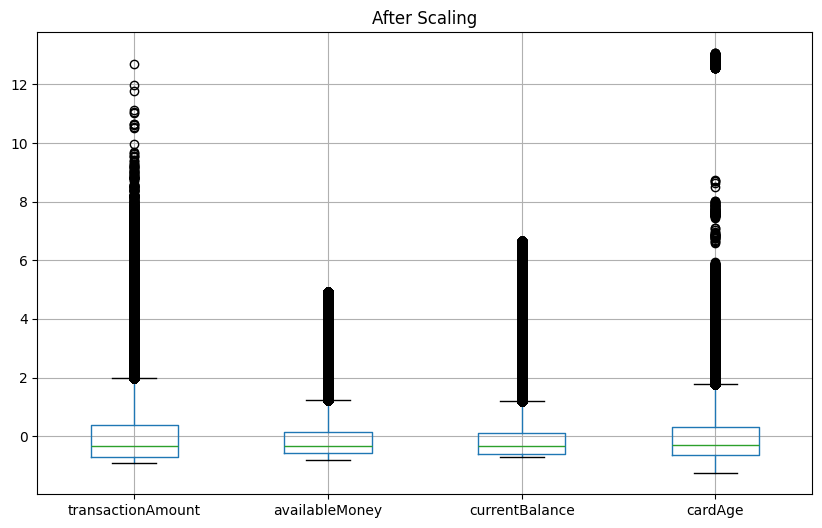

In [87]:
plt.figure(figsize=(10, 6))
df_logistic[numerical_cols].boxplot()
plt.title('After Scaling')
plt.show()

# Modeling

### Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, ConfusionMatrixDisplay

In [88]:
X = df_logistic.drop(['isFraud'], axis=1)
y = df_logistic['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the distribution of the class variable
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
False    0.984262
True     0.015738
Name: proportion, dtype: float64
isFraud
False    0.984043
True     0.015957
Name: proportion, dtype: float64


In [89]:
#Fit model with default parameter
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

ValueError: could not convert string to float: ''

In [92]:
df_logistic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787719 entries, 0 to 787718
Data columns (total 46 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   availableMoney                             787719 non-null  float64
 1   transactionAmount                          787719 non-null  float64
 2   currentBalance                             787719 non-null  float64
 3   cardPresent                                787719 non-null  bool   
 4   expirationDateKeyInMatch                   787719 non-null  bool   
 5   isFraud                                    787719 non-null  bool   
 6   mercharchantState                          1 non-null       object 
 7   isMatchedCVV                               787719 non-null  bool   
 8   cardAge                                    787718 non-null  float64
 9   acqCountry_CAN                             787719 non-null  bool   
 10  acqCount

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

    plt.show()

    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes
    sns.kdeplot(data=results_df[results_df['true_class'] == 0], x='default_prob', legend="No Default", fill=True)
    sns.kdeplot(data=results_df[results_df['true_class'] == 1], x='default_prob', legend="Default", fill=True)

    plt.show()

    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))


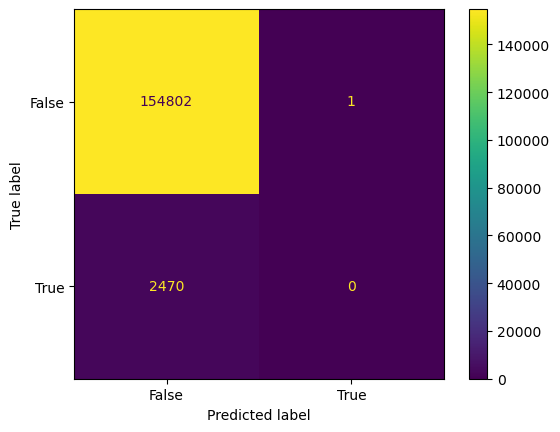



Accuracy:  0.9842884665517921
Precision:  0.0
Recall:  0.0
F1:  0.0
AUC:  0.7502360019228826


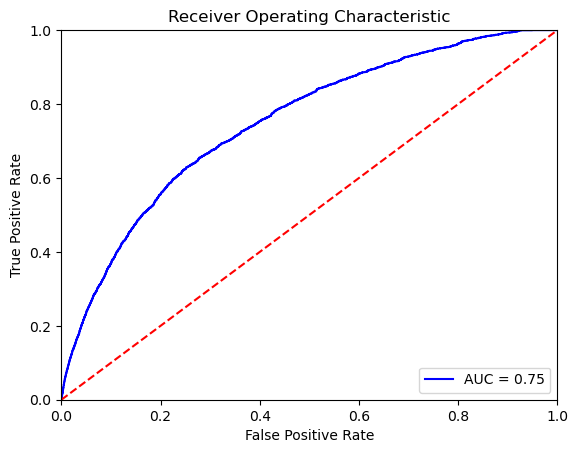

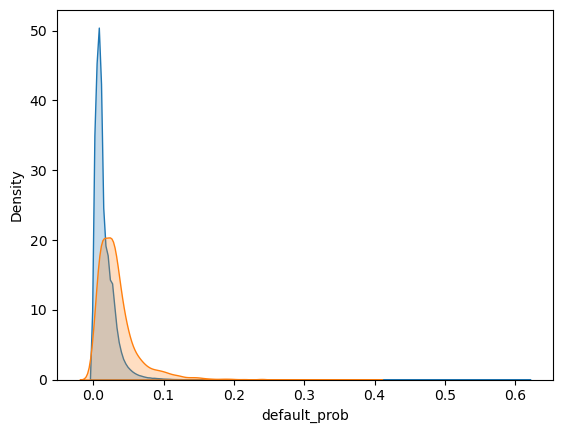

true_class  predicted_class
False       False              0.999994
            True               0.000006
True        False              1.000000
Name: proportion, dtype: float64


In [ ]:
eval_model(logistic_model, X_test, y_test)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_rfc = df

X = df_rfc.drop(['isFraud'], axis=1)
y = df_rfc['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
False    0.984188
True     0.015812
Name: proportion, dtype: float64
isFraud
False    0.984295
True     0.015705
Name: proportion, dtype: float64


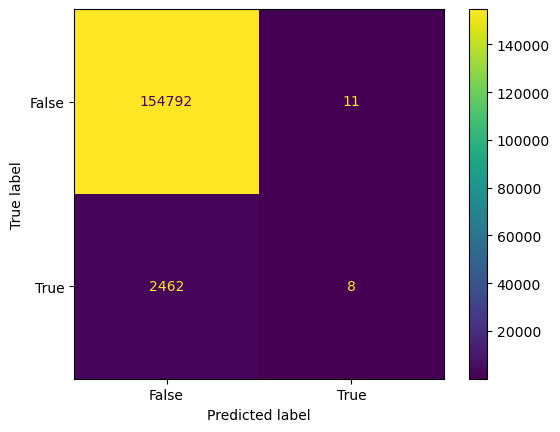



Accuracy:  0.9842757498108384
Precision:  0.42105263157894735
Recall:  0.0032388663967611335
F1:  0.0064282844515869825
AUC:  0.7019159443106755


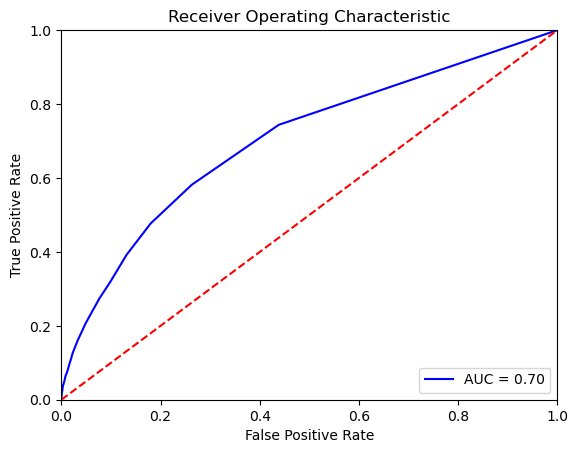

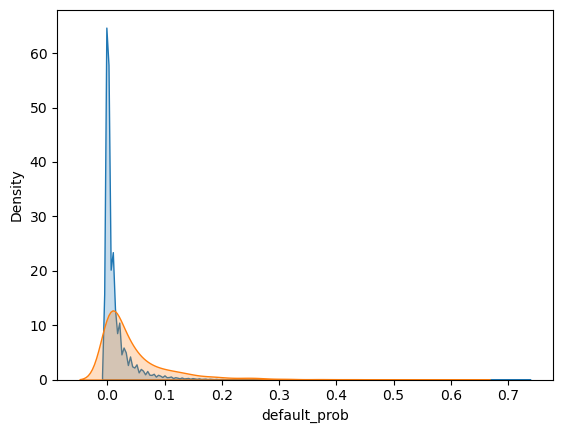

true_class  predicted_class
False       False              0.999929
            True               0.000071
True        False              0.996761
            True               0.003239
Name: proportion, dtype: float64


In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

eval_model(rfc_model, X_test, y_test)

With default parameters, Random Forest seems to have better performance than Logistic Regression so I will investigate more into Random Forest.

### Random Forest with simple parameters

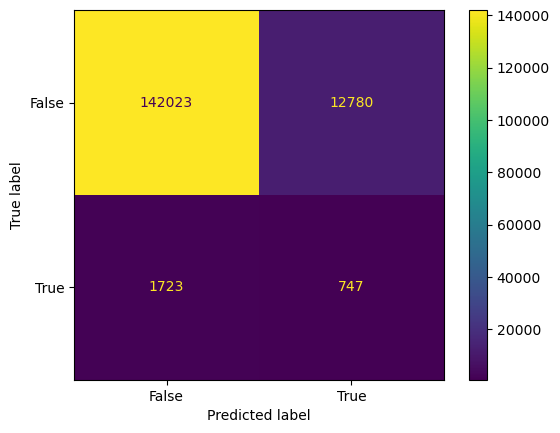



Accuracy:  0.9077845529747637
Precision:  0.0552228875582169
Recall:  0.30242914979757085
F1:  0.09339251109583047
AUC:  0.7499471066020674


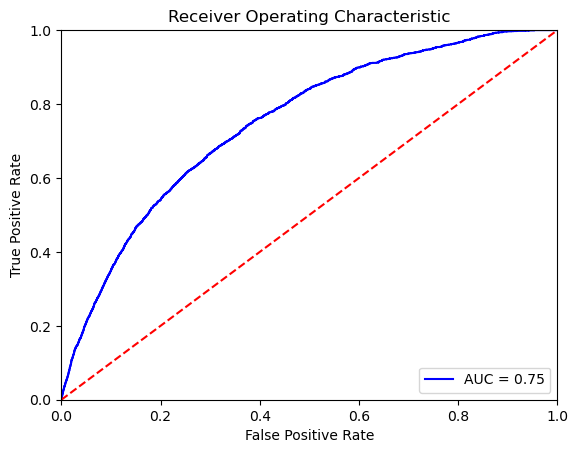

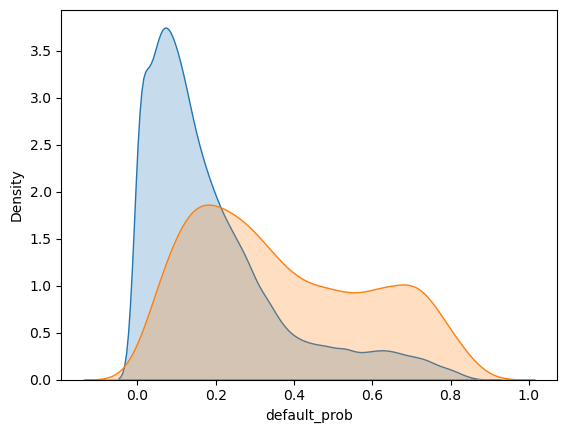

true_class  predicted_class
False       False              0.917443
            True               0.082557
True        False              0.697571
            True               0.302429
Name: proportion, dtype: float64


In [ ]:
rfc_model = RandomForestClassifier(class_weight='balanced', max_depth=25)
rfc_model.fit(X_train, y_train)

eval_model(rfc_model, X_test, y_test)

### Upsampling and Downsampling

In [ ]:
from sklearn.utils import resample

In [ ]:
def balance_sample(X_train, y_train, sample_mode='up'):
    train_df = X_train.copy()
    train_df['isFraud'] = y_train

    train_minority = train_df[train_df['isFraud'] == 1]
    train_majority = train_df[train_df['isFraud'] == 0]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    X_train_samp = train_sampled_df.drop(['isFraud'], axis=1)
    y_train_samp = train_sampled_df['isFraud']

    return X_train_samp, y_train_samp

In [ ]:
X_train_dwn, y_train_dwn = balance_sample(X_train, y_train, sample_mode='down')

print(y_train_dwn.value_counts())
print(y_train_dwn.value_counts(normalize=True))

isFraud
True     9947
False    9947
Name: count, dtype: int64
isFraud
True     0.5
False    0.5
Name: proportion, dtype: float64


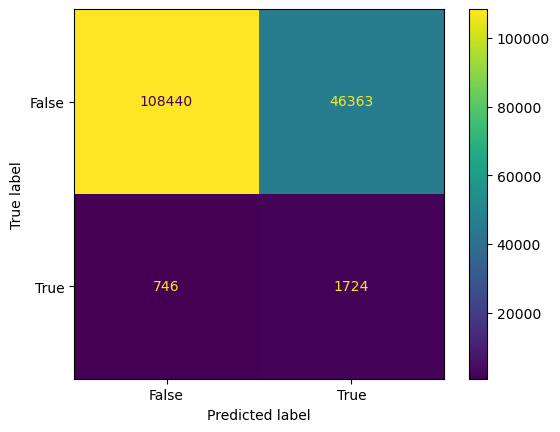



Accuracy:  0.7004635252077598
Precision:  0.03585168548672198
Recall:  0.6979757085020243
F1:  0.06820024922364855
AUC:  0.7640542605789608


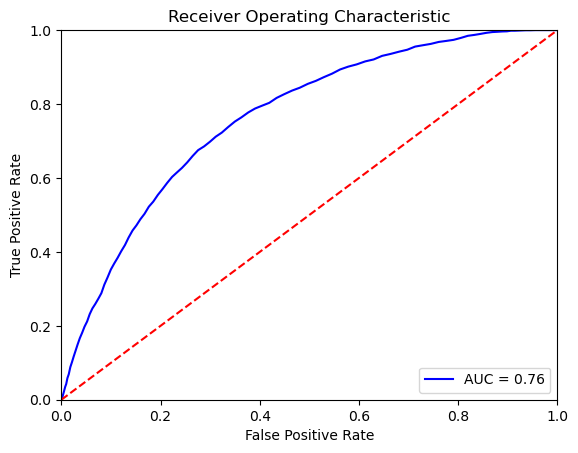

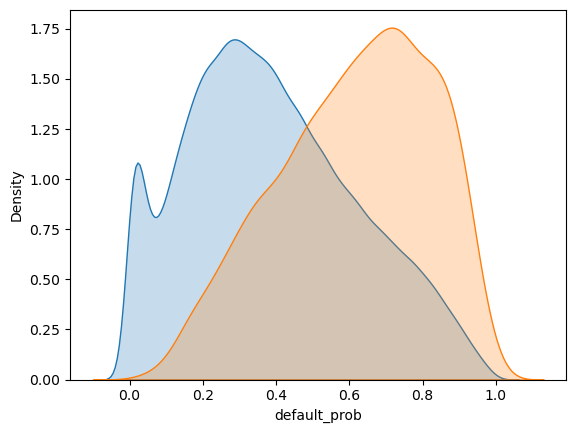

true_class  predicted_class
False       False              0.700503
            True               0.299497
True        True               0.697976
            False              0.302024
Name: proportion, dtype: float64


In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_dwn, y_train_dwn)

eval_model(rfc_model, X_test, y_test)

In [ ]:
X_train_up, y_train_up = balance_sample(X_train, y_train, sample_mode='up')

print(y_train_up.value_counts())
print(y_train_up.value_counts(normalize=True))

isFraud
False    619143
True     619143
Name: count, dtype: int64
isFraud
False    0.5
True     0.5
Name: proportion, dtype: float64


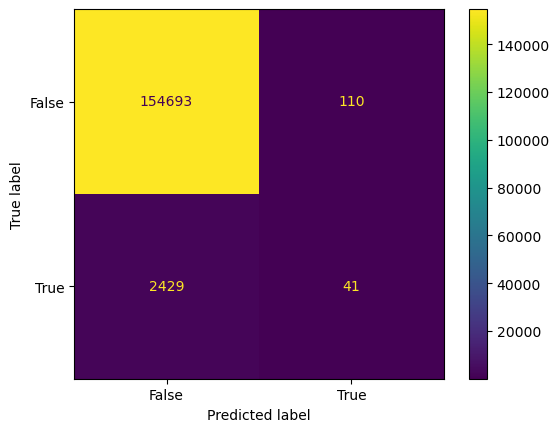



Accuracy:  0.9838560973593687
Precision:  0.271523178807947
Recall:  0.01659919028340081
F1:  0.03128576879053796
AUC:  0.7092666973547496


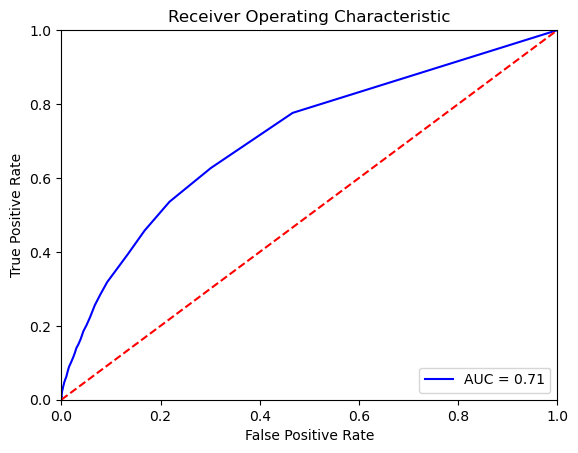

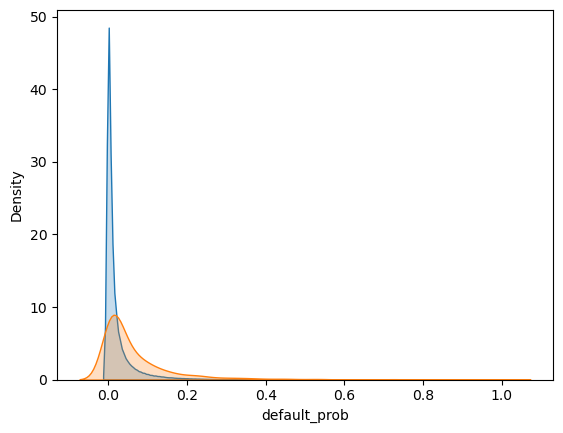

true_class  predicted_class
False       False              0.999289
            True               0.000711
True        False              0.983401
            True               0.016599
Name: proportion, dtype: float64


In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_up, y_train_up)

eval_model(rfc_model, X_test, y_test)

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: isFraud
False    619143
True       9947
Name: count, dtype: int64
After SMOTE: isFraud
False    619143
True     619143
Name: count, dtype: int64


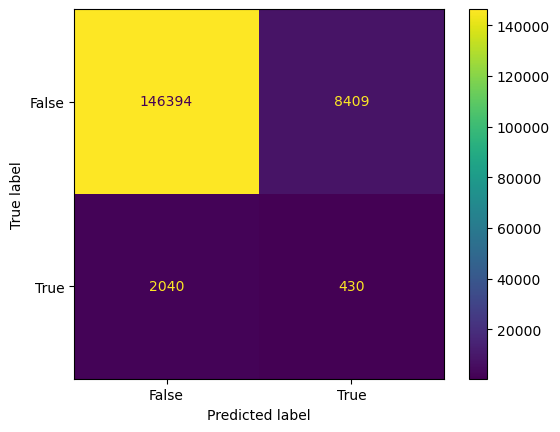



Accuracy:  0.9335613868877684
Precision:  0.04864803710827017
Recall:  0.17408906882591094
F1:  0.07604562737642585
AUC:  0.7255510065672863


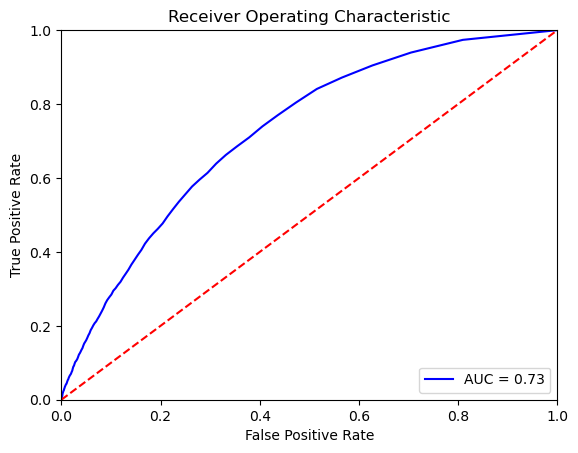

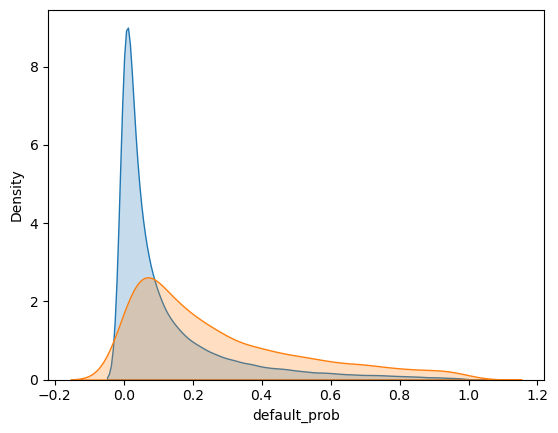

true_class  predicted_class
False       False              0.945679
            True               0.054321
True        False              0.825911
            True               0.174089
Name: proportion, dtype: float64


In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_smote, y_train_smote)

eval_model(rfc_model, X_test, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.4 MB/s eta 0:00:00a 0:00:01


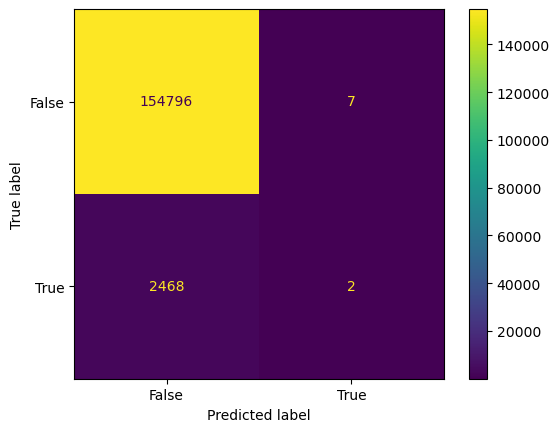



Accuracy:  0.9842630330698848
Precision:  0.2222222222222222
Recall:  0.0008097165991902834
F1:  0.0016135538523598225
AUC:  0.791058209518531


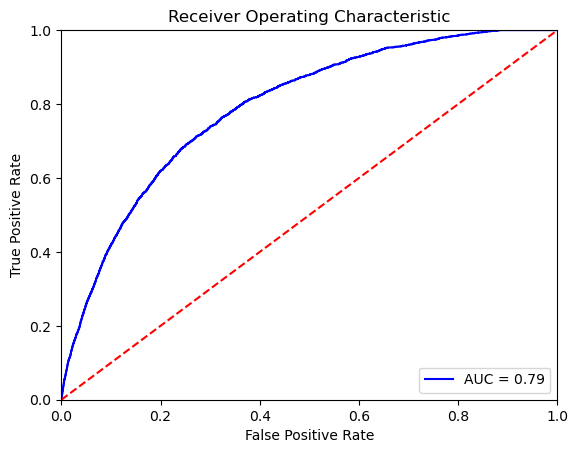

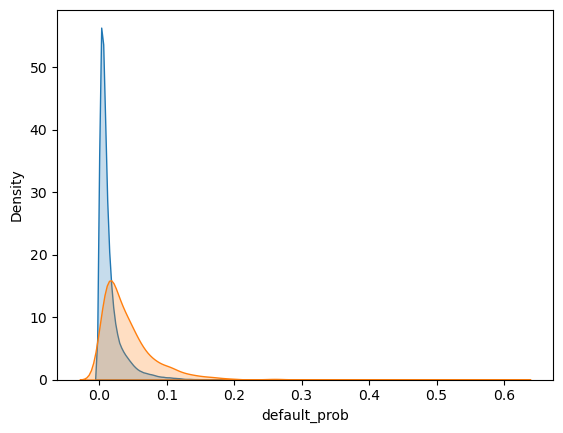

true_class  predicted_class
False       0                  0.999955
            1                  0.000045
True        0                  0.999190
            1                  0.000810
Name: proportion, dtype: float64


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Define the model
xgb_model = XGBClassifier()

# 2. Fit the model
xgb_model.fit(X_train, y_train)

eval_model(xgb_model, X_test, y_test)
